In [3]:
%load_ext autoreload
%autoreload 2

import abc
import numpy as np
#import scipy.interp
import matplotlib
import scipy.linalg
matplotlib.rcParams["xtick.labelsize"] = 20
matplotlib.rcParams["ytick.labelsize"] = 20
matplotlib.rcParams["image.cmap"] = "inferno"
matplotlib.rcParams["axes.titlesize"] = 25
matplotlib.rcParams["axes.labelsize"] = 25
from matplotlib import pyplot as plt
from typing import Optional

import modulated_tls
import floquet_analysis
import pulse
import single_photon_scattering
import two_photon_scattering

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Photon transport a simple modulated two-level system

In [4]:
# Some constant parameters.
gamma = 1.0
delta_max = 5.0 * gamma
inp_freqs = np.linspace(-15 * gamma, 15 * gamma, 1000)

# Fast modulation regime.
freq_fast = 10.0 * gamma
num_harmonics_fast = 500
delta = pulse.SinusoidalPulse(0, delta_max, 0.0, freq_fast)
tls_obj = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta)
floquet_obj = floquet_analysis.FloquetAnalyzer(tls_obj, 500)

_, green_funcs_fast = single_photon_scattering.compute_single_ph_gfunc(
        floquet_obj, inp_freqs)
trans_fast = np.sum(np.abs(green_funcs_fast)**2, axis=1)

# Intermediate modulation regime.
freq_inter = 2.5 * gamma
delta = pulse.SinusoidalPulse(0, delta_max, 0.0, freq_inter)
tls_obj = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta)
floquet_obj = floquet_analysis.FloquetAnalyzer(tls_obj, 500)

_, green_funcs_inter = single_photon_scattering.compute_single_ph_gfunc(
        floquet_obj, inp_freqs)
trans_inter = np.sum(np.abs(green_funcs_inter)**2, axis=1)

# Slow modulation regime.
freq_slow = 0.25 * gamma
delta = pulse.SinusoidalPulse(0, delta_max, 0.0, freq_slow)
tls_obj = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta)
floquet_obj = floquet_analysis.FloquetAnalyzer(tls_obj, 2000)

_, green_funcs_slow = single_photon_scattering.compute_single_ph_gfunc(
        floquet_obj, inp_freqs)
trans_slow = np.sum(np.abs(green_funcs_slow)**2, axis=1)

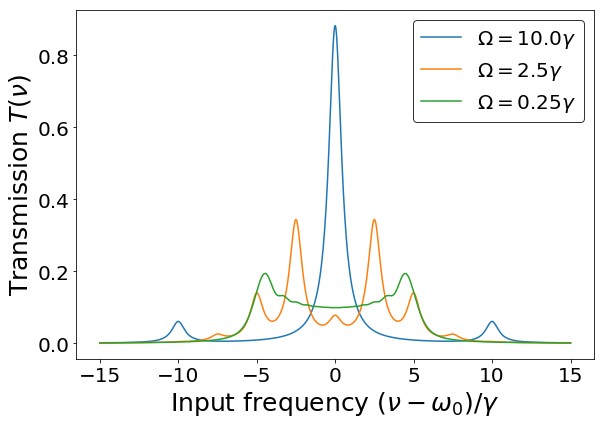

In [165]:
plt.figure(figsize=(8.5, 6))
plt.plot(inp_freqs, 0.25 * trans_fast,
         label="$\Omega = {}\gamma$".format(freq_fast / gamma))
plt.plot(inp_freqs, 0.25 * trans_inter,
         label="$\Omega = {}\gamma$".format(freq_inter / gamma))
# plt.plot(inp_freqs, 0.25 * trans_inter_2,
#          label="$\Omega = {}\gamma$".format(freq_inter_2 / gamma))
plt.plot(inp_freqs, 0.25 * trans_slow,
         label="$\Omega  = {}\gamma$".format(freq_slow / gamma))
plt.xlabel(r"Input frequency $(\nu - \omega_0) / \gamma$")
plt.ylabel(r"Transmission $T(\nu)$")
plt.legend(fontsize=20, edgecolor="k")
plt.tight_layout()
plt.savefig("results/tls_figures/full_tran.pdf")

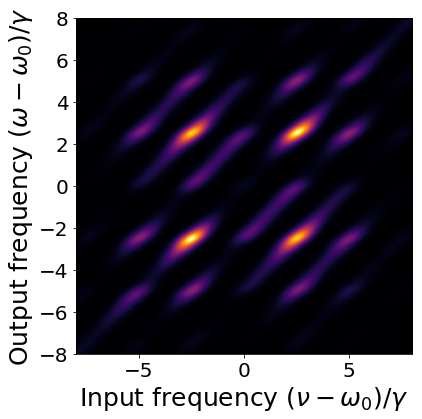

In [5]:
# Generate heatmap with an input gaussian mode.
cen_freqs = np.linspace(-8 * gamma, 8 * gamma, 500)
dw = 0.75 * gamma
out_states = []
num_harm_plot = 5
harmonic_freqs = np.arange(-num_harm_plot, num_harm_plot + 1) * freq_inter
out_freqs = np.linspace(-8 * gamma, 8 * gamma, 1000)

# Interpolate the green's functions.
gfuncs_interp = []
for gfunc in green_funcs_inter[:, (num_harmonics_fast - num_harm_plot) :
                                 (num_harmonics_fast + num_harm_plot + 1)].T:
    gfuncs_interp.append(scipy.interpolate.interp1d(
        inp_freqs, gfunc, bounds_error=False, fill_value=0))

for cen_freq in cen_freqs:
    out_state = 0
    for k, harm in enumerate(harmonic_freqs):
        in_state_shifted = np.exp(-(out_freqs - (cen_freq + harm))**2 / dw**2)
        out_state += (gfuncs_interp[k](out_freqs - harm) * in_state_shifted)
    out_states.append(out_state)
    
plt.figure(figsize=(8.5, 6))
plt.imshow((np.abs(np.array(out_states)**2)).T, aspect=1,
           origin="lower",
           extent=[cen_freqs[0], cen_freqs[-1],
                   out_freqs[0], out_freqs[-1]])
plt.ylabel(r"Output frequency $(\omega - \omega_0) / \gamma$")
plt.xlabel(r"Input frequency $(\nu - \omega_0) / \gamma$")
plt.tight_layout()
plt.savefig("results/tls_figures/smat_heatmap.pdf")

In [6]:
# Analyzing the two-photon correlation function.
gamma = 1.0
delta_max = 5.0 * gamma
freq_fast = 5.0 * gamma
num_per_fast = 10
delta = pulse.SinusoidalPulse(0, delta_max, 0.0, freq_fast)
tls_obj = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta)
floquet_obj = floquet_analysis.FloquetAnalyzer(tls_obj, 800)
# The correlation function.
input_freqs = np.array([0])
psi_out_fast = two_photon_scattering.compute_two_ph_output(
    floquet_obj, input_freqs, num_per_fast)
g2_fast = two_photon_scattering.compute_g2(
    floquet_obj, input_freqs, num_per_fast)

# Analyzing the two-photon correlation function.
gamma = 1.0
delta_max = 5.0 * gamma
freq_inter = 2.5 * gamma
num_per_inter = 8
delta = pulse.SinusoidalPulse(0, delta_max, 0.0, freq_inter)
tls_obj = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta)
floquet_obj = floquet_analysis.FloquetAnalyzer(tls_obj, 800)
# The correlation function.
input_freqs = np.array([0])
psi_out_inter = two_photon_scattering.compute_two_ph_output(
    floquet_obj, input_freqs, num_per_inter)
g2_inter = two_photon_scattering.compute_g2(
    floquet_obj, input_freqs, num_per_inter)

# Analyzing the two-photon correlation function.
gamma = 1.0
delta_max = 5.0 * gamma
freq_slow = 0.25 * gamma
num_per_slow = 4
delta = pulse.SinusoidalPulse(0, delta_max, 0.0, freq_slow)
tls_obj = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta)
floquet_obj = floquet_analysis.FloquetAnalyzer(tls_obj, 1000)
# The correlation function.
input_freqs = np.array([0])
psi_out_slow = two_photon_scattering.compute_two_ph_output(
    floquet_obj, input_freqs, num_per_slow)
g2_slow = two_photon_scattering.compute_g2(
    floquet_obj, input_freqs, num_per_slow)

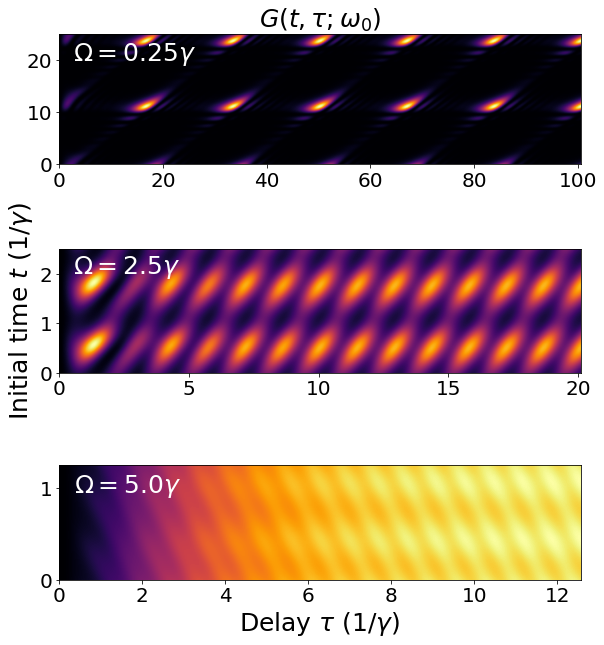

In [36]:
plt.figure(figsize=(8.5, 9))
plt.subplot(3, 1, 1)
plt.imshow(np.abs(psi_out_slow[0])**2,
           extent=[0, 2 * np.pi * gamma * num_per_slow / freq_slow,
                   0, 2 * np.pi * gamma / freq_slow])
plt.text(x=2.7, y=20, s="$\Omega = {}\gamma$".format(freq_slow), color="w", fontsize=25)
plt.title(r"$G(t, \tau; \omega_0)$")

plt.subplot(3, 1, 2)
plt.imshow(np.abs(psi_out_inter[0])**2,
           extent=[0, 2 * np.pi * gamma * num_per_inter / freq_inter,
                   0, 2 * np.pi * gamma / freq_inter], aspect=1.9)
plt.title("$\Omega = {}\gamma$".format(freq_inter), x=0.13, y=0.75, color="w")

plt.xticks([0, 5, 10, 15, 20])
plt.ylabel("Initial time $t \ (1/\gamma)$")


plt.subplot(3, 1, 3)
plt.imshow(np.abs(psi_out_fast[0])**2, origin="lower",
           extent=[0, 2 * np.pi * gamma * num_per_fast / freq_fast,
                   0, 2 * np.pi * gamma / freq_fast],
           aspect=2.2)
plt.text(x=0.35, y=0.95, s="$\Omega = {}\gamma$".format(freq_fast),
         color="w", fontsize=25)
plt.yticks([0, 1])
plt.xlabel(r"Delay $\tau \ (1/\gamma)$")
plt.tight_layout()
plt.savefig("results/tls_figures/psi_out.pdf")

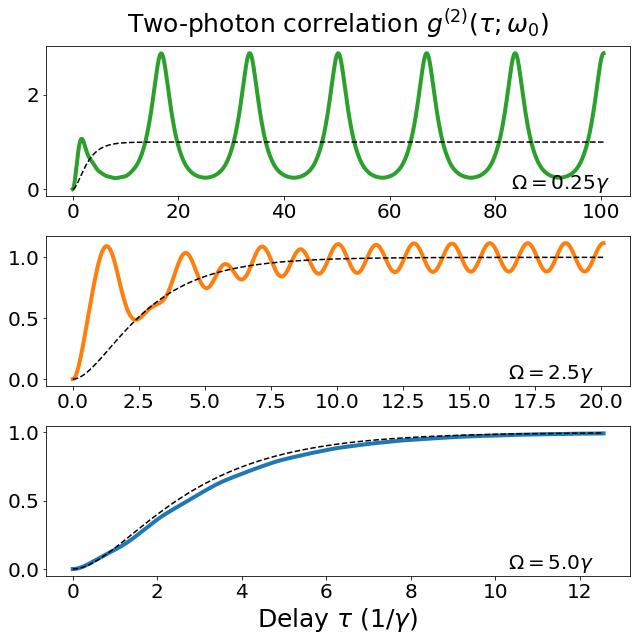

In [37]:
def constant_g2(times, gamma) -> np.array:
    return np.abs(1 - np.exp(-gamma * times / 2))**2


plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
times_slow = np.linspace(0, 2 * np.pi * num_per_slow / freq_slow, g2_slow[0].size)
plt.plot(times_slow, g2_slow[0], color="C2", linewidth=4)
plt.plot(times_slow, constant_g2(times_slow, gamma), linestyle="--", color="k")
plt.text(x=83, y=0, s=r"$\Omega = {}\gamma$".format(freq_slow), fontsize=20)
plt.title(r"Two-photon correlation $g^{(2)}(\tau; \omega_0)$", y=1.05)

plt.subplot(3, 1, 2)
times_inter = np.linspace(0, 2 * np.pi * num_per_inter / freq_inter, g2_inter[0].size)
plt.plot(times_inter, g2_inter[0], color="C1", linewidth=4)
plt.plot(times_inter, constant_g2(times_inter, gamma), linestyle="--", color="k")
plt.text(x=16.5, y=0, s=r"$\Omega = {}\gamma$".format(freq_inter), fontsize=20)

plt.subplot(3, 1, 3)
times_fast = np.linspace(0, 2 * np.pi * num_per_fast / freq_fast, g2_fast[0].size)
plt.plot(times_fast, g2_fast[0], color="C0", linewidth=4)
plt.plot(times_fast, constant_g2(times_fast, gamma), linestyle="--", color="k")
plt.text(x=10.3, y=0, s=r"$\Omega = {}\gamma$".format(freq_fast), fontsize=20)
plt.xlabel(r"Delay $\tau \ (1/\gamma)$")

plt.tight_layout()
plt.savefig("results/tls_figures/g2.pdf")

## Two-photon calculation for optimized systems

Text(0.5, 1.0, 'Four color design')

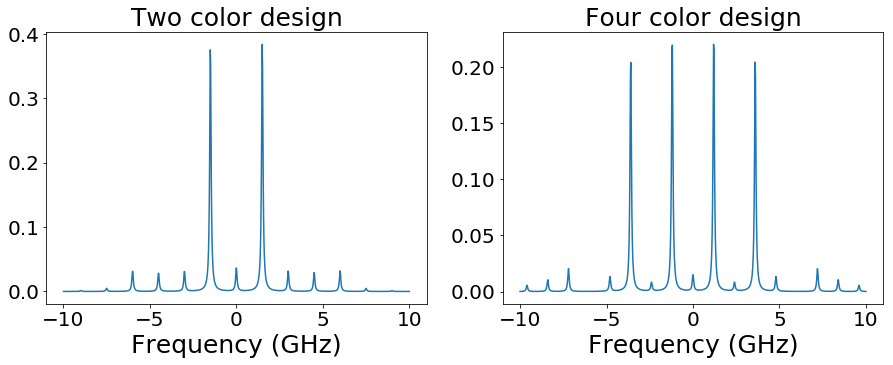

In [209]:
# Reproducing transmission spectrum.
gamma = 98
inp_freqs = np.linspace(-10000, 10000, 1000)

# Two frequency modulation.
freq_2f = 1500
amps = [2910, 2250]
phases = [0, 0]
harmonics = [1, 3]
delta_2f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_2f)
tls_obj_2f = modulated_tls.ModulatedTwoLevelSystem(
    0, gamma, delta_2f)
floquet_obj_2f = floquet_analysis.FloquetAnalyzer(tls_obj_2f, 500)

inp_freqs = np.linspace(-10000, 10000, 1000)
_, green_funcs_2f = single_photon_scattering.compute_single_ph_gfunc(
        floquet_obj, inp_freqs)
trans_2f = 0.25 * np.sum(np.abs(green_funcs_2f)**2, axis=1)

# Four frequency modulation.
freq_4f = 1200
amps = [2360, 2110, 2220, 2020, 2250]
phases = [np.pi / 6, -np.pi / 6, np.pi / 2, -5 * np.pi / 6, 5 * np.pi / 6]
harmonics = [1, 2, 3, 4, 5]
delta_4f = pulse.MultiSinusoidalPulse(amps, phases, harmonics, freq_4f)
tls_obj_4f = modulated_tls.ModulatedTwoLevelSystem(
        0, gamma, delta_4f)
floquet_obj_4f = floquet_analysis.FloquetAnalyzer(tls_obj_4f, 500)

_, green_funcs_4f = single_photon_scattering.compute_single_ph_gfunc(
        floquet_obj_4f, inp_freqs)
trans_4f = 0.25 * np.sum(np.abs(green_funcs_4f)**2, axis=1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(inp_freqs / 1000, trans_2f)
plt.xlabel("Frequency (GHz)")
plt.title("Two color design")

plt.subplot(1, 2, 2)
plt.plot(inp_freqs / 1000, trans_4f)
plt.xlabel("Frequency (GHz)")
plt.title("Four color design")

In [214]:
# Calculate the g2 values.
num_periods = 50
g2_2f = two_photon_scattering.compute_g2(floquet_obj_2f, np.array([0]),
                                         num_periods)
g2_4f = two_photon_scattering.compute_g2(floquet_obj_4f, np.array([0]),
                                         num_periods)

Text(0.5, 1.0, 'Four color design')

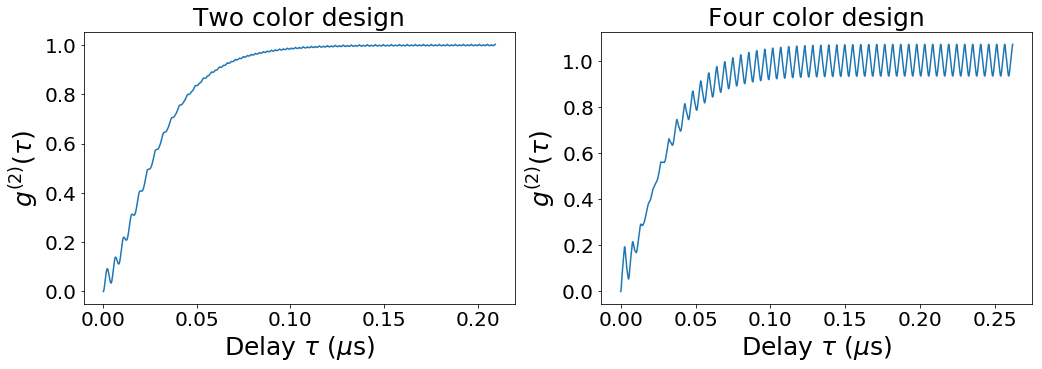

In [221]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, num_periods * 2 * np.pi / freq_2f, g2_2f.size), g2_2f[0])
plt.xlabel(r"Delay $\tau$ ($\mu$s)")
plt.ylabel(r"$g^{(2)}(\tau)$")
plt.title("Two color design")

plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, num_periods * 2 * np.pi / freq_4f, g2_4f.size),
         g2_4f[0])
plt.xlabel(r"Delay $\tau$ ($\mu$s)")
plt.ylabel(r"$g^{(2)}(\tau)$")
plt.title("Four color design")